In [29]:
import os

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import make_swiss_roll

from models import *
from utils import *

### Swiss roll dataset

We will start experimenting with a simple distribution, as it is the swiss roll distribution. We will be based on the Sohl Dickstein (https://arxiv.org/abs/1503.03585) and Jonathan Ho (https://arxiv.org/abs/2006.11239) papers

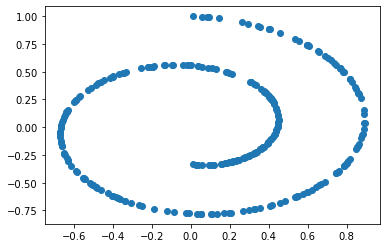

In [2]:
def make_dataset(n_samples=300):
    """
    Returns a normalized swiss roll dataset in a (n_samples, 2) matrix, where
    each rows corresponds to a single sample, and each column to a component (x or y).
    """
    points = make_swiss_roll(n_samples=n_samples)[0][:, [0,2]]
    # Normalize the data so it lies between [-1 and 1]
    max_value = np.max(points)
    points[:, 0], points[:, 1] = points[:, 0]/max_value, points[:, 1]/max_value
    return points

points = make_dataset(n_samples=300)
plt.plot(points[:, 0], points[:, 1], color='C0', marker='o', ls='')
plt.show()

### Forward diffusion process

A Gaussian kernel is applied at every step. Given that T is sufficiently large and $\beta$ is considerably small, the final distribution will be a well behaved isotropic gaussian.

$$q(x^{(t)}|x^{(t-1)}) = \mathcal{N}\left(x^{(t)}; \sqrt{1 - \beta_t}x^{(t-1)}, \mathbb{I}\beta_t\right)$$

In the Ho et al. (2021) paper, they use $T=1000$, and the variances are scheduled to increase linearly from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$.
To obtain $x_t$, we could iteratively apply $q(x_t \mid x_{t-1})$, or we can use the following expression to compute it directly:

$$q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha} _t} x_0, (1 - \bar{\alpha} _t) \mathbb{I})$$

where $\alpha _t = 1 - \beta _t$ and $\bar{\alpha} _t = \prod _{s=1}^t \alpha _s$. It can also be written as:

$$x_t = \sqrt{\bar{\alpha} _t} x_0 + \sqrt{1 - \bar{\alpha} _t}z, \qquad z \sim \mathcal{N}(0, \mathbb{I})$$

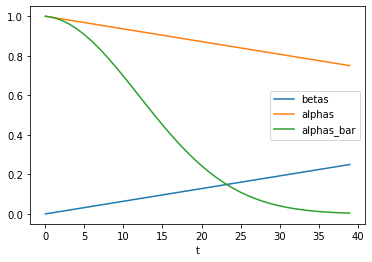

In [19]:
def schedule_variances(beta_1=1e-4, beta_T = 0.25, T=40):
    """
    Schedule the variances used in the forward diffusion step.
    In this case, it will simply perform a linear interpolation between
    beta_1 and beta_T.
    Returns:
        - betas: Array with all the beta_t
        - alphas: (1 - beta_t)
        - alphas_bar: Just the cumulative product of the alphas
    All will be arrays of shape (T, )
    """
    ts = np.arange(T)
    betas = np.interp(ts, [ts[0], ts[-1]], [beta_1, beta_T])
    alphas = (1 - betas)
    alphas_bar = np.cumprod(alphas)
    return betas, alphas, alphas_bar
    
T = 40
betas, alphas, alphas_bar = schedule_variances(T=T)
plt.plot(betas, label='betas')
plt.plot(alphas, label='alphas')
plt.plot(alphas_bar, label='alphas_bar')
plt.xlabel("t")
plt.legend()
plt.show()

As we can see, when increasing $t$, $x_t$ will be closer to a Gaussian distribution of mean 0 and variance 1, as $\bar{ \alpha} _t$ smoothly goes to zero.

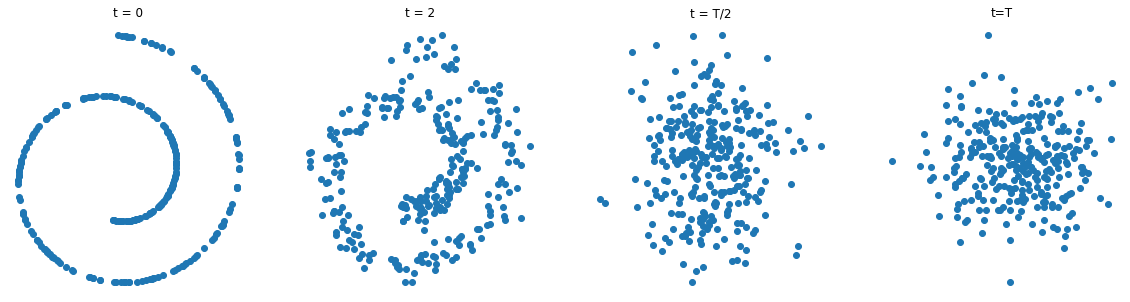

In [26]:
rng = default_rng()

points = make_dataset()
betas, alphas, alphas_bar = schedule_variances()

def forward_q(x_0, t):
    if t <= 0: 
        return x_0
    z = rng.standard_normal(points.shape)
    alpha_bar = alphas_bar[t-1]
    x_t = np.sqrt(alpha_bar)*x_0 + np.sqrt(1 - alpha_bar)*z
    return x_t

x_10 = forward_q(points, 2)
x_50 = forward_q(points, int(T/2))
x_T = forward_q(points, T)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(4*5, 5))
for ax in [ax1, ax2, ax3, ax4]: ax.axis('off')
ax1.plot(points[:, 0], points[:, 1], color='C0', marker='o', ls='')
ax2.plot(x_10[:, 0], x_10[:, 1], color='C0', marker='o', ls='')
ax3.plot(x_50[:, 0], x_50[:, 1], color='C0', marker='o', ls='')
ax4.plot(x_T[:, 0], x_T[:, 1], color='C0', marker='o', ls='')
ax1.set_title("t = 0")
ax2.set_title("t = 2")
ax3.set_title("t = T/2")
ax4.set_title("t=T")
plt.show()

### Reverse diffusion process

We have trained a model that predicts que noise for the sample $x_t$ at timestep $t$ (see `train_swissroll.py`). Now, we will use it to perform the reverse process and recover the original distribution.

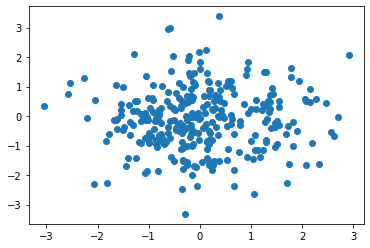

39


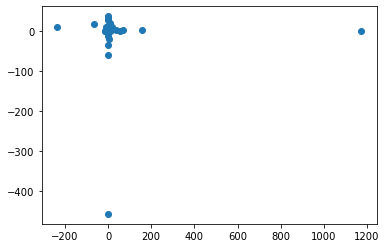

38


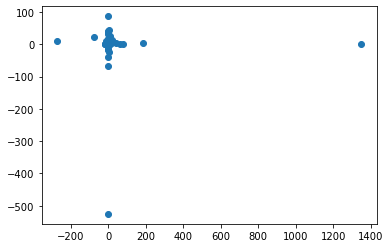

37


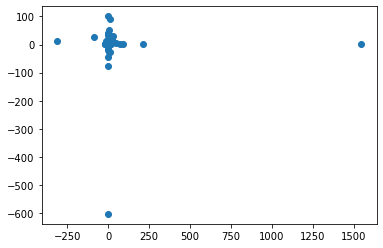

36


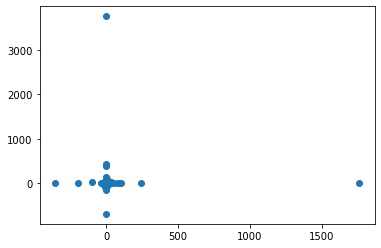

35


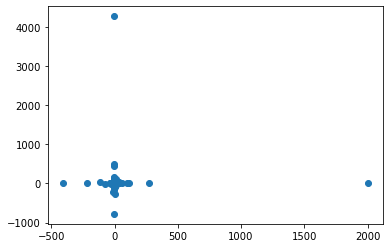

34


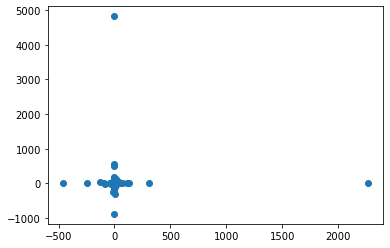

33


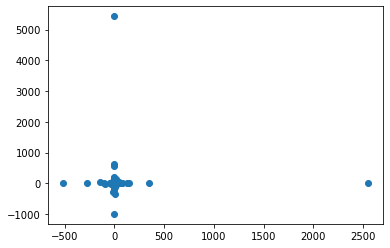

32


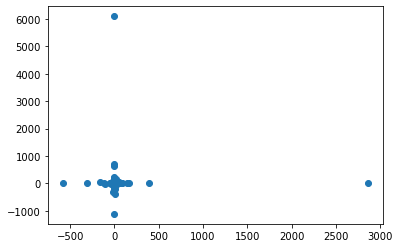

31


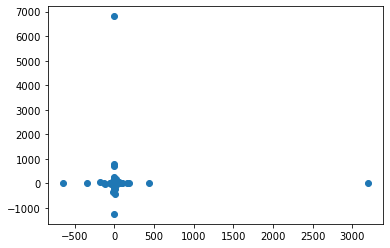

30


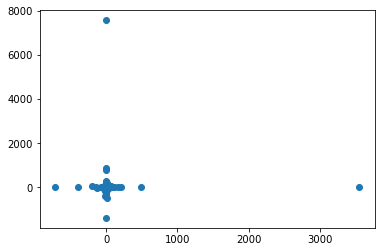

29


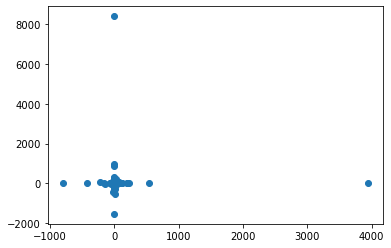

28


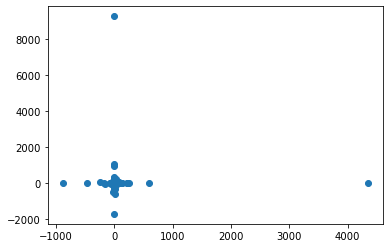

27


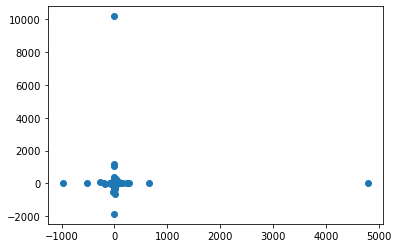

26


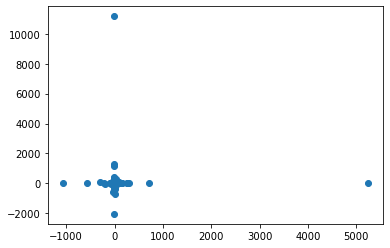

25


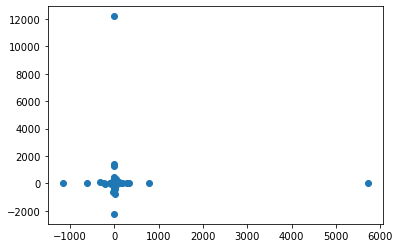

24


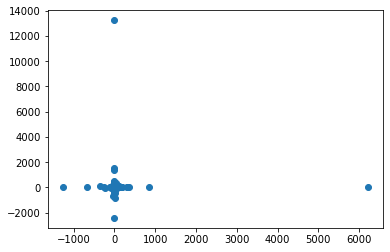

23


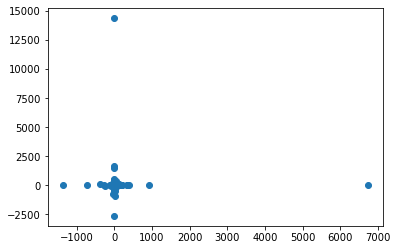

22


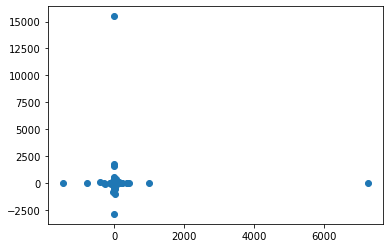

21


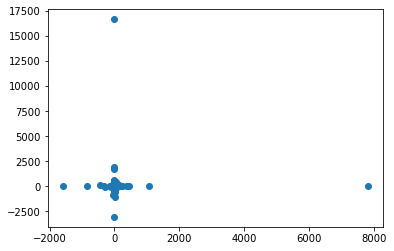

20


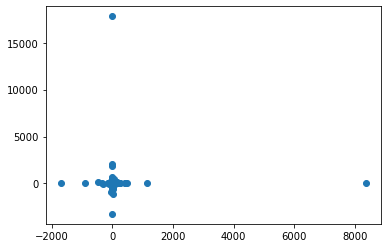

19


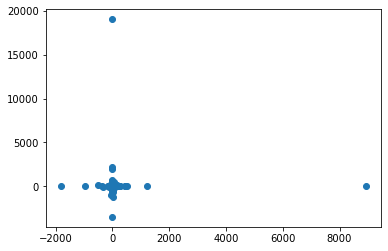

18


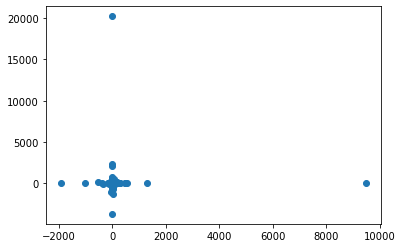

17


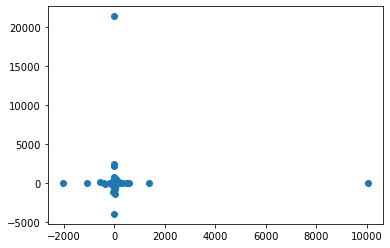

16


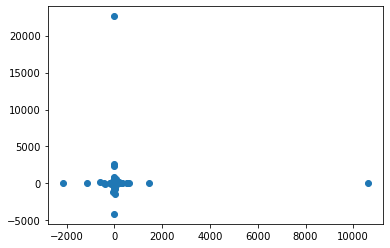

15


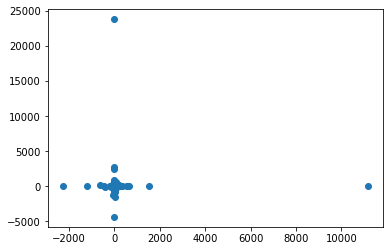

14


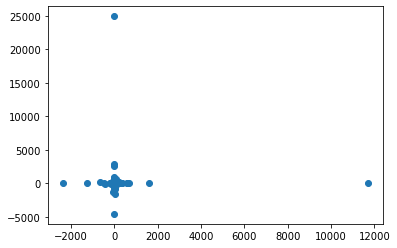

13


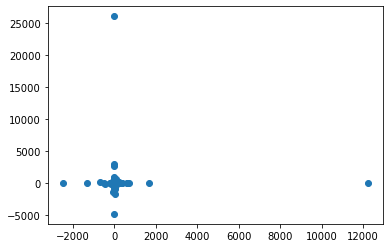

12


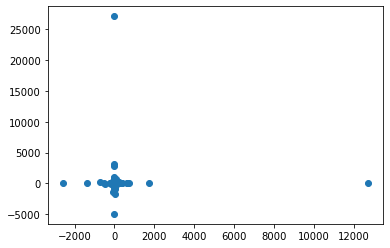

11


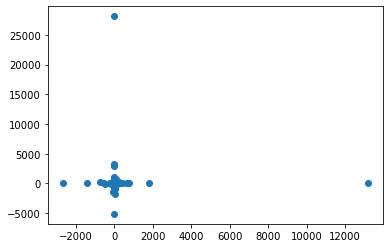

10


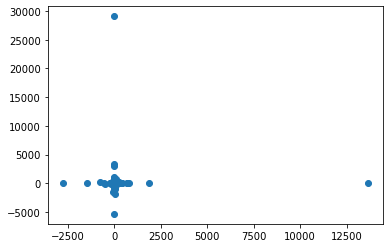

9


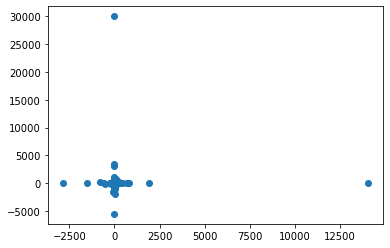

8


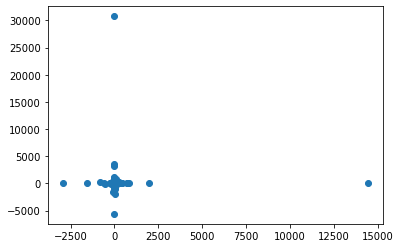

7


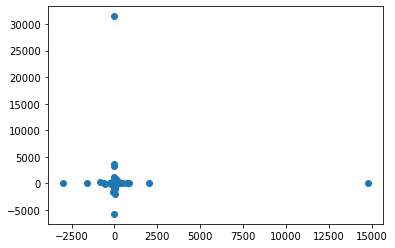

6


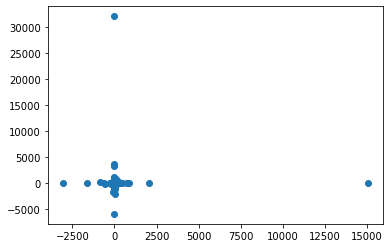

5


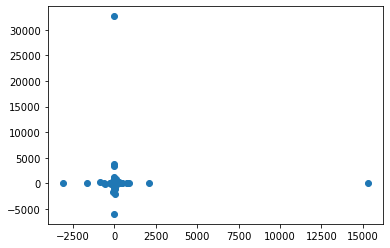

4


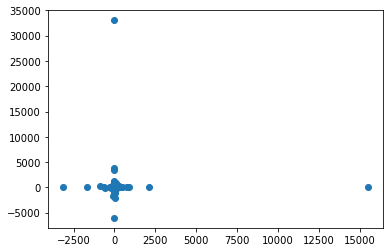

3


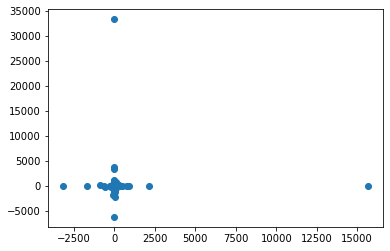

2


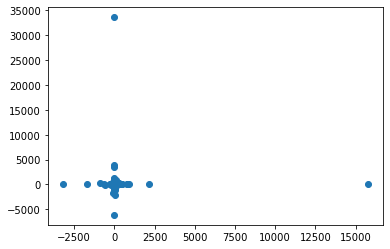

1


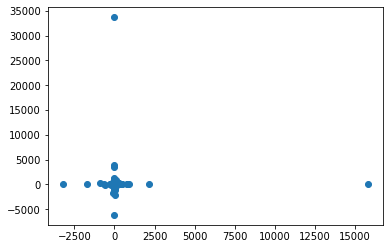

0


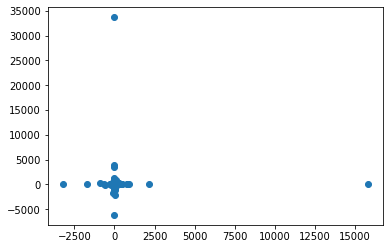

In [43]:
model = SwissRollModel(input_size=2, T=40)
model.load_state_dict(torch.load(os.path.join("saved_models", "test.pth")))

betas, alphas, alphas_bar = schedule_variances(beta_1=1e-4, beta_T=0.25, T=T)
x_t = np.random.normal(size=(300, 2))
plt.plot(x_t[:, 0], x_t[:, 1], color='C0', marker='o', ls='')
plt.show()
for t in range(T-1, -1, -1):
    z = np.random.normal(size=x_t.shape) if t >= 0 else np.zeros(x_t.shape)
    z_pred = model(torch.tensor(x_t, dtype=torch.float32), t)
    z_pred = np.array(z_pred.detach())
    x_t = (x_t - (1-alphas[t])/(np.sqrt(1-alphas_bar[t])*z_pred))/np.sqrt(alphas[t]) + betas[t]*z
    print(t)
    plt.plot(x_t[:, 0], x_t[:, 1], color='C0', marker='o', ls='')
    plt.show()